In [1]:
from datasets import *
from model_prime import *
from model_prime_sw import *

import pandas as pd
import matplotlib.pyplot as plt
import shap

c:\Users\Legers\cross_validation\env_cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 0
L.seed_everything(seed, workers=True)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision("medium")

Seed set to 0


In [3]:
range_z = np.linspace(0, 0.4, 181)[:-1]

test = np.load("datasets\h2f_multiresolution_test_last_kfold1.npz", allow_pickle=True)

imgs_test = torch.tensor(test["imgs"]).float()
z_test_class = torch.tensor(np.digitize(test["metadata"].item()["z"].values,range_z)-1).long()
ebv_test = torch.tensor(test["metadata"].item()["EBV"].values).unsqueeze(1).float()

### Nuevos modelos

In [4]:
class PRIMESW(L.LightningModule):

    def __init__(self, config):
        super(PRIMESW, self).__init__()

        self.convs = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )
        
        self.linear_net = nn.Sequential(
                                nn.Linear(int(((config["img_size"]/8)**2)*348)*config["in_levels"] +1, 1096),
                                nn.ReLU(),
                                nn.Linear(1096, 1096),
                                nn.ReLU(),
                                nn.Linear(1096, 180)
                                )
                                
        
        if config["loss"] == "ce":
            self.loss = nn.CrossEntropyLoss()

        self.lr = config["lr"]
        self.in_levels= config["in_levels"]

        self.training_predictions = []
        self.training_classes = []

        self.val_predictions = []
        self.val_classes = []

        self.curves = {
                        "train_loss": [],
                        "val_loss": [],
                    }
        
        self.config = config
        self.save_hyperparameters(config)

                
    def forward(self, x, ebv):

        x = torch.cat([self.convs(x[:,i,:,:,:]) for i in range(self.in_levels)] + [ebv], dim=1)

        output = self.linear_net(x)
        return output,x
    
    def training_step(self, batch, batch_idx):
        x,ebv,y_class = batch
        x_hat,_ = self.forward(x,ebv)
        train_loss = self.loss(x_hat, y_class)

        self.training_predictions.append(x_hat.detach().cpu())
        self.training_classes.append(y_class.cpu())
        
        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, batch, batch_idx):

        x,ebv,y_class = batch
        x_hat,_ = self.forward(x,ebv)
        val_loss = self.loss(x_hat, y_class)

        self.val_predictions.append(x_hat.cpu())
        self.val_classes.append(y_class.cpu())

        self.log("val_loss", val_loss, prog_bar=True)
        
        return val_loss
    
    def on_train_epoch_end(self):

        predictions = torch.cat(self.training_predictions, dim=0)
        classes = torch.cat(self.training_classes, dim=0)

        self.curves["train_loss"].append(self.loss(predictions, classes))

        self.training_predictions.clear() 
        self.training_classes.clear()  

    def on_validation_epoch_end(self):

        predictions = torch.cat(self.val_predictions, dim=0)
        classes = torch.cat(self.val_classes, dim=0)

        self.curves["val_loss"].append(self.loss(predictions, classes))

        self.val_predictions.clear() 
        self.val_classes.clear() 

    def predict_step(self, batch):
        x,ebv,_ = batch    
        return self(x,ebv)[1]
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0, last_epoch=-1)

        return [optimizer], [scheduler]

In [5]:
class PRIME_noSW(L.LightningModule):

    def __init__(self, config):
        super(PRIME_noSW, self).__init__()

        self.convs1 = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )
        
    
        self.convs2 = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )


        self.convs3 = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )
    
        self.convs4 = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )
    
        self.convs5 = nn.Sequential(
                                nn.Conv2d(config["in_channels"], 64, kernel_size=5, padding="same"),
                                nn.PReLU(num_parameters=64, init=0.0),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(64,nbS1=48, nbS2=64, with_kernel_5=True),
                                InceptionBlock(240,nbS1=64, nbS2=92, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(340,nbS1=92, nbS2=128, with_kernel_5=True),
                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=True),
                                nn.AvgPool2d(kernel_size=2, stride=2, padding=0),

                                InceptionBlock(476,nbS1=92, nbS2=128, with_kernel_5=False),
                                nn.Flatten()
                                )
        
        self.linear_net = nn.Sequential(
                                nn.Linear(int(((config["img_size"]/8)**2)*348)*config["in_levels"] +1, 1096),
                                nn.ReLU(),
                                nn.Linear(1096, 1096),
                                nn.ReLU(),
                                nn.Linear(1096, 180)
                                )
                                        
        if config["loss"] == "ce":
            self.loss = nn.CrossEntropyLoss()

        self.lr = config["lr"]
        self.in_levels= config["in_levels"]

        self.training_predictions = []
        self.training_classes = []

        self.val_predictions = []
        self.val_classes = []

        self.curves = {
                        "train_loss": [],
                        "val_loss": [],
                    }
        
        self.config = config
        self.save_hyperparameters(config)
                
    def forward(self, x, ebv):
        x1 = self.convs1(x[:,0,:,:,:])
        x2 = self.convs2(x[:,1,:,:,:])
        x3 = self.convs3(x[:,2,:,:,:])
        x4 = self.convs4(x[:,3,:,:,:])
        x5 = self.convs5(x[:,4,:,:,:])

        x = torch.cat([x1,x2,x3,x4,x5,ebv], dim=1)
        
        output = self.linear_net(x)
        return output,x
    
    def training_step(self, batch, batch_idx):
        x,ebv,y_class = batch
        x_hat,_ = self.forward(x,ebv)
        train_loss = self.loss(x_hat, y_class)

        self.training_predictions.append(x_hat.detach().cpu())
        self.training_classes.append(y_class.cpu())
        
        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, batch, batch_idx):

        x,ebv,y_class = batch
        x_hat,_ = self.forward(x,ebv)
        val_loss = self.loss(x_hat, y_class)

        self.val_predictions.append(x_hat.cpu())
        self.val_classes.append(y_class.cpu())

        self.log("val_loss", val_loss, prog_bar=True)
        
        return val_loss
    
    def on_train_epoch_end(self):

        predictions = torch.cat(self.training_predictions, dim=0)
        classes = torch.cat(self.training_classes, dim=0)

        self.curves["train_loss"].append(self.loss(predictions, classes))

        self.training_predictions.clear() 
        self.training_classes.clear()  

    def on_validation_epoch_end(self):

        predictions = torch.cat(self.val_predictions, dim=0)
        classes = torch.cat(self.val_classes, dim=0)

        self.curves["val_loss"].append(self.loss(predictions, classes))

        self.val_predictions.clear() 
        self.val_classes.clear() 

    def predict_step(self, batch):
        x,ebv,_ = batch    
        return self(x,ebv)[1]
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0, last_epoch=-1)

        return [optimizer], [scheduler]

### Predicciones

In [6]:
model_SW = PRIMESW.load_from_checkpoint("resultados\prime_12345\cv/fold1\last.ckpt")
model_NOSW = PRIME_noSW.load_from_checkpoint("resultados\prime_12345_sw\cv/fold1\last.ckpt")

batch_size=128
num_workers=4

dm = GalaxyDataModule(imgs_train=imgs_test,
            imgs_test=imgs_test,
            z_train_class=z_test_class,
            z_test_class=z_test_class,
            ebv_train=ebv_test,
            ebv_test=ebv_test,
            batch_size=batch_size,
            seed=seed,
            num_workers=num_workers
            )

trainer = L.Trainer(
                num_sanity_val_steps=0,
                logger=False,
                deterministic=True,
                max_epochs=40,
                accelerator ="gpu",
                devices = "auto")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
pred_sw =torch.cat(trainer.predict(model=model_SW, datamodule =dm), dim=0)
pred_nosw =torch.cat(trainer.predict(model=model_NOSW, datamodule =dm), dim=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 808/808 [00:59<00:00, 13.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 808/808 [01:17<00:00, 10.47it/s]


### MLP

In [11]:
class MLP_SW(L.LightningModule):
    def __init__(self):
        super(MLP_SW, self).__init__()
        self.model = model_SW.linear_net
        self.soft = nn.Softmax()

    def forward(self, x):
        return self.soft(self.model(x))

In [12]:
class MLP_noSW(L.LightningModule):
    def __init__(self):
        super(MLP_noSW, self).__init__()
        self.model = model_NOSW.linear_net
        self.soft = nn.Softmax()

    def forward(self, x):
        return self.soft(self.model(x))

### SHAP

In [13]:
mlp_sw = MLP_SW()
mlp_nosw = MLP_noSW()

In [17]:
mask = test["metadata"].item()["petroR90_r"].values<10
mask.sum()

93474

In [16]:
ejemplos_sw = pred_sw[mask][:10]
ejemplos_nosw = pred_nosw[mask][:10]

In [18]:
explainer_sw = shap.DeepExplainer(mlp_sw, ejemplos_sw)
explainer_nosw = shap.DeepExplainer(mlp_nosw, ejemplos_nosw)

c:\Users\Legers\cross_validation\env_cv\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [19]:
shap_values_sw = explainer_sw.shap_values(ejemplos_sw)
shap_values_nosw = explainer_nosw.shap_values(ejemplos_nosw)

In [20]:
importancia_sw = np.abs(shap_values_sw).mean(0).sum(1)
importancia_nosw = np.abs(shap_values_nosw).mean(0).sum(1)

In [21]:
mean_all_sw  =0
mean_all_nosw  =0

for i in range(5):
    mean_all_sw+= importancia_sw[:-1][i*5568:(i+1)*5568].mean()
    mean_all_nosw+= importancia_nosw[:-1][i*5568:(i+1)*5568].mean()

for i in range(5):
    print(round(importancia_sw[:-1][i*5568:(i+1)*5568].mean()/mean_all_sw,5),  round(importancia_nosw[:-1][i*5568:(i+1)*5568].mean()/mean_all_nosw,5))

0.41866 0.44983
0.23995 0.15396
0.13759 0.17478
0.10191 0.16278
0.10189 0.05865


In [22]:
mean_all_sw  =0
mean_all_nosw  =0

for i in range(5):
    mean_all_sw+= importancia_sw[:-1][i*5568:(i+1)*5568].mean()
    mean_all_nosw+= importancia_nosw[:-1][i*5568:(i+1)*5568].mean()

for i in range(5):
    print(round(importancia_sw[:-1][i*5568:(i+1)*5568].mean()/mean_all_sw,5),  round(importancia_nosw[:-1][i*5568:(i+1)*5568].mean()/mean_all_nosw,5))

0.41866 0.44983
0.23995 0.15396
0.13759 0.17478
0.10191 0.16278
0.10189 0.05865


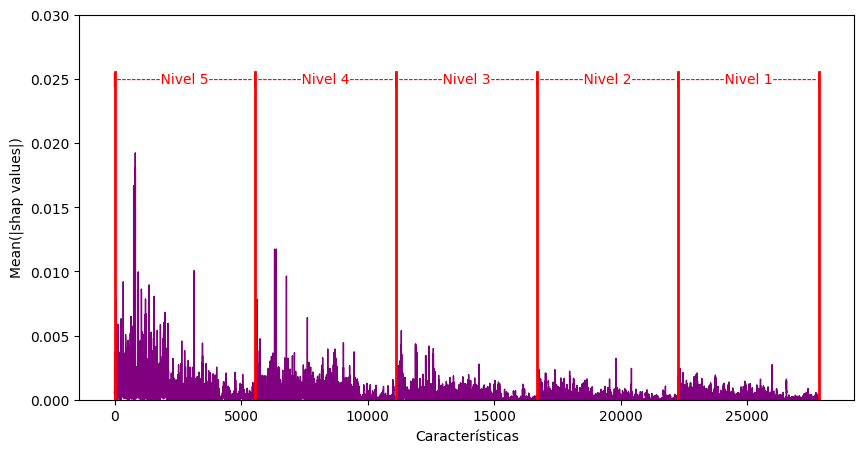

In [24]:
# Crear la figura y el eje
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(np.arange(27841)[:-1], importancia_sw[:-1], linewidth=1, color="purple")
axs.set_ylim([0, 0.03])

# Añadir líneas verticales y etiquetas de nivel
for n in range(6):
    x_pos = 5568 * n
    if n!=0:
        axs.text(x_pos - 2784, 0.025, f'|---------Nivel {6-n}---------|', rotation=0, verticalalignment='center', horizontalalignment='center', fontsize=10,color="red")
    axs.plot([x_pos, x_pos], [0, 0.0255], color='red', linestyle='-', linewidth=2)

axs.set_ylabel("Mean(|shap values|)")

axs.set_xlabel("Características")
plt.show()

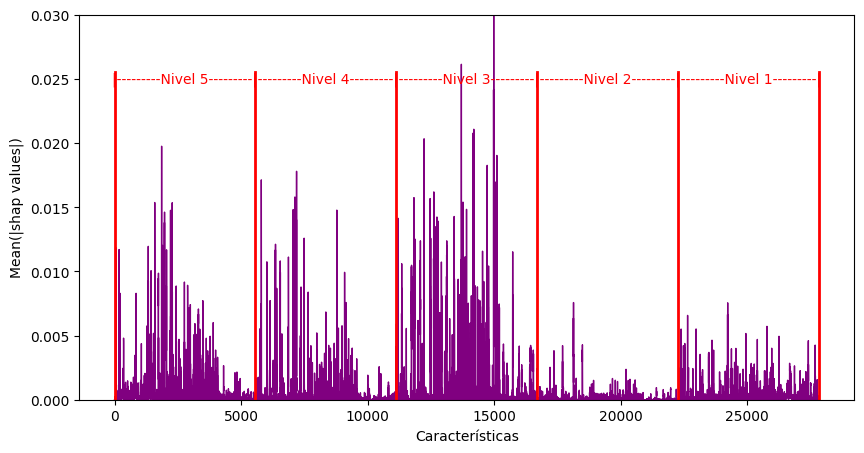

In [78]:
# Crear la figura y el eje
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(np.arange(27841)[:-1], importancia_nosw[:-1], linewidth=1, color="purple")
axs.set_ylim([0, 0.03])

# Añadir líneas verticales y etiquetas de nivel
for n in range(6):
    x_pos = 5568 * n
    if n!=0:
        axs.text(x_pos - 2784, 0.025, f'|---------Nivel {6-n}---------|', rotation=0, verticalalignment='center', horizontalalignment='center', fontsize=10,color="red")
    axs.plot([x_pos, x_pos], [0, 0.0255], color='red', linestyle='-', linewidth=2)

axs.set_ylabel("Mean(|shap values|)")

axs.set_xlabel("Características")
plt.show()